This notebook demonstrates how to prepare the MELD dataset and train a baseline transformer-based emotion classifier using Hugging Face 🤗 Transformers and Datasets. We will:
- Load and preprocess data,
- Fine-tune a model on MELD,
- Evaluate accuracy,
- Plot training/validation learning curves.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorWithPadding
)
import torch
sns.set(style="whitegrid")


e:\chatbot_emotion\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0730 11:57:43.878000 22628 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [3]:
# Set file paths
train_path = '../data/datasets/MELD/formatted_train_sent_emo.csv'
val_path = '../data/datasets/MELD/formatted_dev_sent_emo.csv'

# Load CSVs
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

# Confirm basic info
print(train_df.head())
print(val_df['Emotion'].value_counts())

# Prepare Dataset objects & label encodings
label2id = {label: idx for idx, label in enumerate(sorted(train_df['Emotion'].unique()))}
id2label = {idx: label for label, idx in label2id.items()}

train_df['labels'] = train_df['Emotion'].map(label2id)
val_df['labels'] = val_df['Emotion'].map(label2id)

# Keep needed columns
train_data = Dataset.from_pandas(train_df[['Utterance', 'labels']])
val_data = Dataset.from_pandas(val_df[['Utterance', 'labels']])
train_data = train_data.rename_column("Utterance", "text")
val_data = val_data.rename_column("Utterance", "text")


   Sr No.                                          Utterance          Speaker  \
0       1  also I was the point person on my companys tr...         Chandler   
1       2                   You mustve had your hands full.  The Interviewer   
2       3                            That I did. That I did.         Chandler   
3       4      So lets talk a little bit about your duties.  The Interviewer   
4       5                             My duties?  All right.         Chandler   

    Emotion Sentiment  Dialogue_ID  Utterance_ID  Season  Episode  \
0   neutral   neutral            0             0       8       21   
1   neutral   neutral            0             1       8       21   
2   neutral   neutral            0             2       8       21   
3   neutral   neutral            0             3       8       21   
4  surprise  positive            0             4       8       21   

      StartTime       EndTime  \
0  00:16:16,059  00:16:21,731   
1  00:16:21,940  00:16:23,442   

In [4]:
MODEL_NAME = "distilbert-base-uncased"  # Choose base model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding=True)

train_data = train_data.map(tokenize_fn, batched=True)
val_data = val_data.map(tokenize_fn, batched=True)

train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 1109/1109 [00:00<00:00, 37492.91 examples/s]


In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./output_emotion_baseline",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    seed=42,
    report_to="none"  # turn off external logging
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
e:\chatbot_emotion\venv\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
from datasets import load_metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return metric.compute(predictions=preds, references=labels)


C:\Users\KUMAR ABHISHEK\AppData\Local\Temp\ipykernel_22628\476392344.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
e:\chatbot_emotion\venv\lib\site-packages\datasets\load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [7]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

result = trainer.train()


  0%|          | 0/1875 [00:00<?, ?it/s]e:\chatbot_emotion\venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 27%|██▋       | 500/1875 [10:58<29:56,  1.31s/it]

{'loss': 1.2439, 'grad_norm': 3.135953187942505, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}


                                                  
 33%|███▎      | 625/1875 [14:04<23:34,  1.13s/it]

{'eval_loss': 1.2153829336166382, 'eval_accuracy': 0.5969341749323716, 'eval_runtime': 11.8519, 'eval_samples_per_second': 93.572, 'eval_steps_per_second': 2.953, 'epoch': 1.0}


e:\chatbot_emotion\venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 53%|█████▎    | 1000/1875 [23:02<19:37,  1.35s/it] 

{'loss': 1.0193, 'grad_norm': 5.573312282562256, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}


                                                   
 67%|██████▋   | 1250/1875 [28:45<10:22,  1.00it/s]

{'eval_loss': 1.177607536315918, 'eval_accuracy': 0.5942290351668169, 'eval_runtime': 11.799, 'eval_samples_per_second': 93.991, 'eval_steps_per_second': 2.966, 'epoch': 2.0}


e:\chatbot_emotion\venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 80%|████████  | 1500/1875 [35:02<09:38,  1.54s/it]

{'loss': 0.847, 'grad_norm': 7.458963871002197, 'learning_rate': 1e-05, 'epoch': 2.4}


                                                   
100%|██████████| 1875/1875 [43:28<00:00,  1.03s/it]

{'eval_loss': 1.2573878765106201, 'eval_accuracy': 0.5897204688908927, 'eval_runtime': 11.0695, 'eval_samples_per_second': 100.185, 'eval_steps_per_second': 3.162, 'epoch': 3.0}


100%|██████████| 1875/1875 [43:29<00:00,  1.39s/it]

{'train_runtime': 2609.3574, 'train_samples_per_second': 11.484, 'train_steps_per_second': 0.719, 'train_loss': 0.9760456217447917, 'epoch': 3.0}


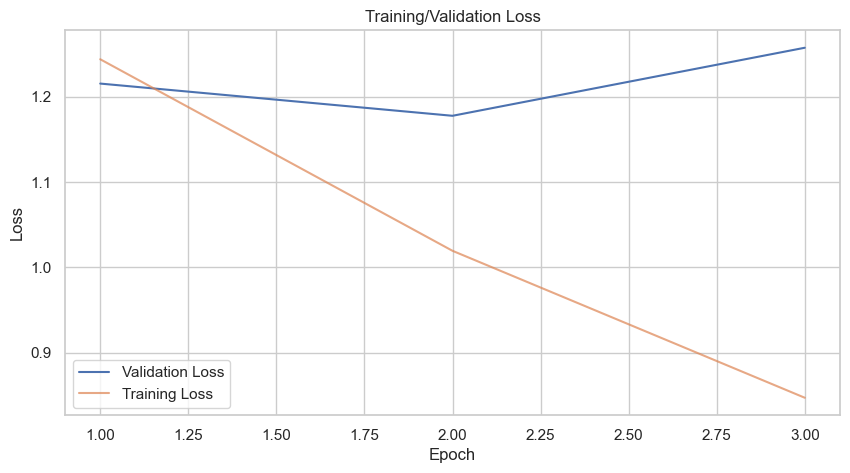

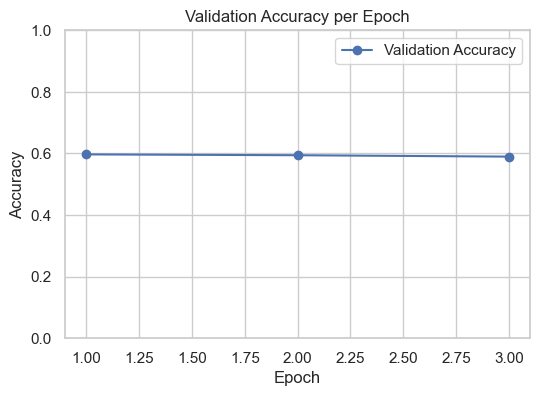

In [8]:
# Extract training history
history = trainer.state.log_history

train_loss = [x['loss'] for x in history if 'loss' in x and 'epoch' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
epochs = list(range(1, len(eval_loss) + 1))

# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.plot(range(1, len(train_loss)+1), train_loss, label='Training Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(6,4))
plt.plot(epochs, eval_acc, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.show()


In [9]:
trainer.save_model("./output_emotion_baseline")
tokenizer.save_pretrained("./output_emotion_baseline")


('./output_emotion_baseline\\tokenizer_config.json',
 './output_emotion_baseline\\special_tokens_map.json',
 './output_emotion_baseline\\vocab.txt',
 './output_emotion_baseline\\added_tokens.json',
 './output_emotion_baseline\\tokenizer.json')